## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
#!pip install -q hyperopt

In [3]:
%matplotlib inline

In [62]:
# для работы с таблицами
import pandas as pd

# для EDA анализа
import ydata_profiling

# для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# для масштабирования признаков
from sklearn.preprocessing import RobustScaler

# для математических вычислений
import numpy as np

# с моделями машинного обучения
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# с константной моделью
from sklearn.dummy import DummyRegressor

# для расчёта качества моделей
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score

# для поиска гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# для расчёта времени выполнения кода
import time

## 2 Открытие файлов с данными и изучение общей информации
### 2.1 Обучающие данные
Считаем данные из csv-файла в датафрейм, сохраним в переменную `train_df` и проведём EDA анализ.

In [5]:
INDEX_COL = 'date'

In [6]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv', index_col=INDEX_COL)
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv', index_col=INDEX_COL)
    ydata_profiling.ProfileReport(df, progress_bar=False).to_file(name + '.html')
    return df

In [7]:
train_df = read_eda('gold_recovery_train_new')

[Посмотреть анализ.](https://www.dropbox.com/s/e5vwrnwdtabbbjo/gold_recovery_train_new.html?dl=0)

- **В данных 14149 строк, 87 столбцов, 2 типа данных: float64, object.**
- **Присутствуют пропуски.**

### 2.2 Тестовые данные
Считаем данные из csv-файла в датафрейм, сохраним в переменную `test_df` и проведём EDA анализ.

In [8]:
test_df = read_eda('gold_recovery_test_new')

[Посмотреть анализ.](https://www.dropbox.com/s/qt1n3daz3gbhk90/gold_recovery_test_new.html?dl=0)

- **В данных 5290 строк, 53 столбца, 2 типа данных: float64, object.**
- **Присутствуют пропуски.**

### 2.3 Исходные данные
Считаем данные из csv-файла в датафрейм, сохраним в переменную `full_df` и проведём EDA анализ.

In [9]:
full_df = read_eda('gold_recovery_full_new')

[Посмотреть анализ.](https://www.dropbox.com/s/aqb3j2jb9flfmx5/gold_recovery_full_new.html?dl=0)

- **В данных 19439 строк, 87 столбцов, 2 типа данных: float64, object.**
- **Присутствуют пропуски.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>После изучения данных, стала ясна их общая структура:</b> 
        <li>В обучающих данных 14149 строк, 87 столбцов, 2 типа данных: float64, object.</li>
        <li>В тестовых данных 5290 строк, 53 столбца, 2 типа данных: float64, object.</li>
        <li>В исходных данных 19439 строк, 87 столбцов, 2 типа данных: float64, object.</li>
        <br>
        <b>Также были обнаружены пропуски в нецелевых признаках, подлежащие обработке.</b>
    </p>  
</div>

## 3 Подготовка данных
### 3.1 Обработка пропусков
#### Обучающие данные
Определим процент пропусков по столбцам.

In [10]:
def nans(df, condition=' > 0'):
    return (df.isna().mean()*100).to_frame().rename(columns = {0:'space'}).query('space' + condition)

In [11]:
def plot_nans(df, figsize):
    try:
        (
            nans(df)
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(10, figsize), legend=False, fontsize=11, grid=True)
            .set_title('Процент пропусков' + "\n", fontsize=18)    
        );    
    except:
        print('Пропусков нет.')

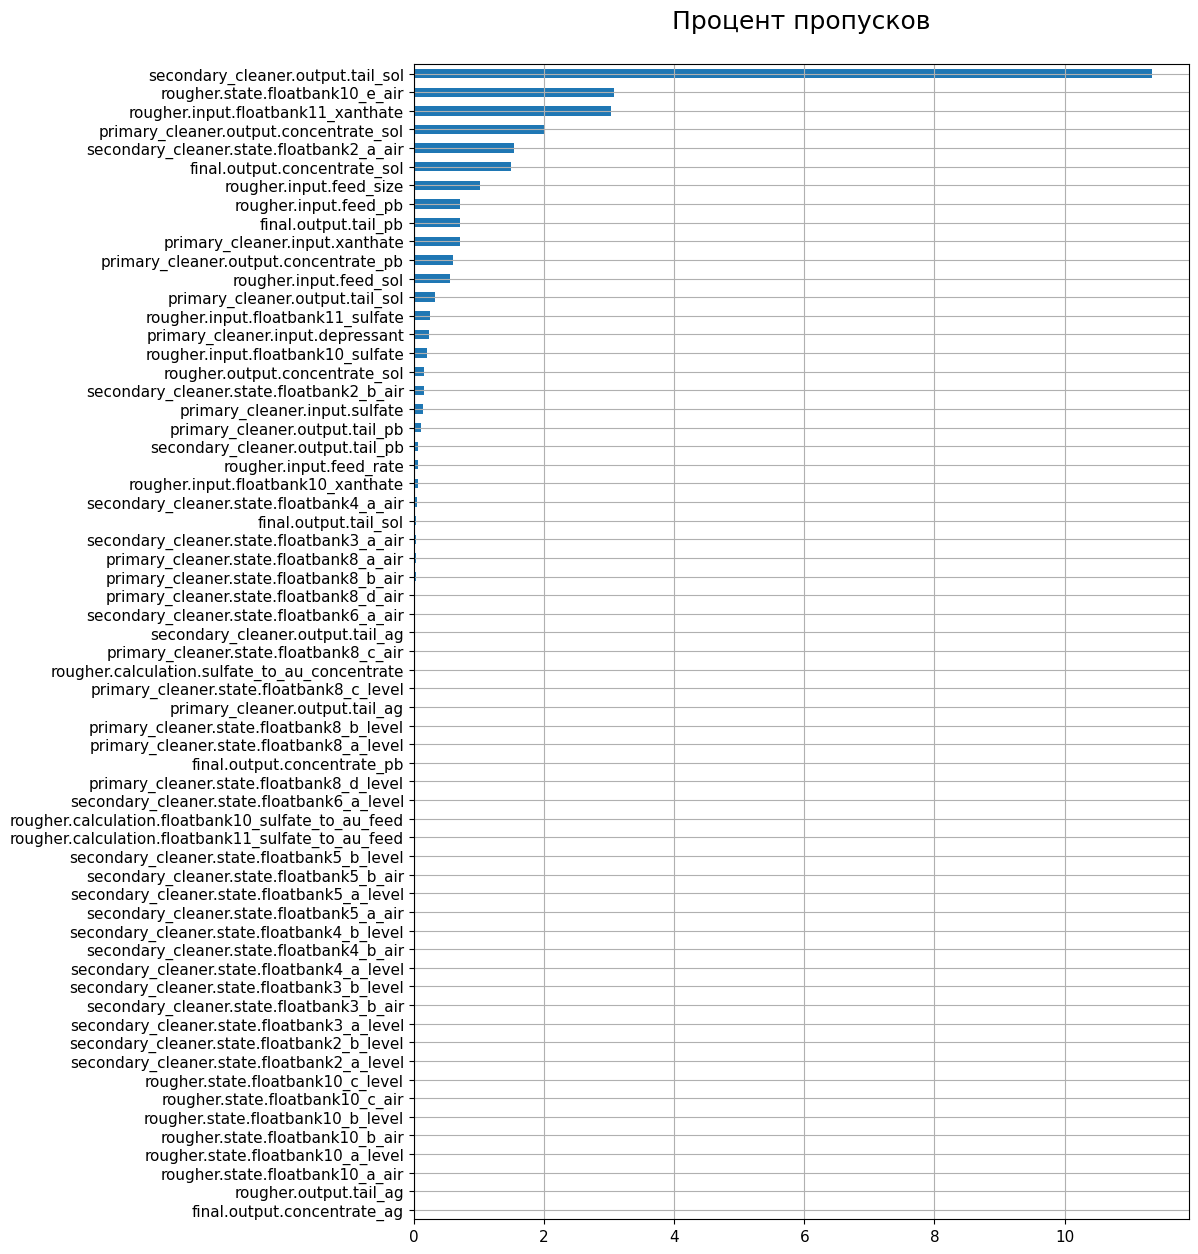

In [12]:
plot_nans(train_df, 15)

Так как данные являются последовательными измерениями, заменим пропуски методом `ffill`, предварительно создав копию исходного датафрейма.

In [13]:
old_train_df = train_df.copy()

train_df = train_df.ffill()

#### Тестовые данные
Определим процент пропусков по столбцам.

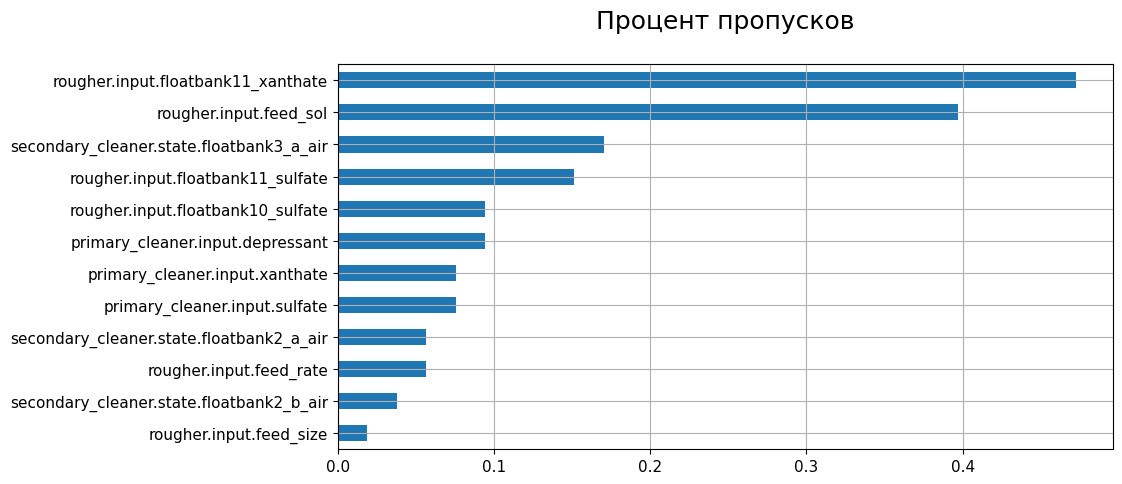

In [14]:
plot_nans(test_df, 5)

Так как данные являются последовательными измерениями, заменим пропуски методом `ffill`, предварительно создав копию исходного датафрейма.

In [15]:
old_test_df = test_df.copy()

test_df = test_df.ffill()

### 3.2 Проверка правильности расчёта эффективности обогащения
Рассчитаем эффективность обогащения.

In [16]:
c = train_df['rougher.output.concentrate_au']
f = train_df['rougher.input.feed_au']
t = train_df['rougher.output.tail_au']

recovery = (c * (f - t)) / (f * (c - t)) * 100

Найдём MAE между расчётами и значением признака.

In [17]:
print('Средняя абсолютная ошибка: ', mean_absolute_error(train_df['rougher.output.recovery'], recovery))

Средняя абсолютная ошибка:  9.73512347450521e-15


**Ошибка относительно небольшая, поэтому можно сказать, что расчёты верны.**

### 3.3 Анализ признаков, недоступных в тестовой выборке
Создадим список с такими признаками.

In [18]:
columns = []

for column in train_df.columns:
    if column not in test_df.columns:
        columns.append(column)

Выведем основную информацию об отсутсвующих признаках. 

In [19]:
train_df[columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                             

- `output` — параметры продукта
- `calculation` — расчётные характеристики

Удалим эти признаки из обучающего датафрейма, предварительно сохранив целевые.

In [20]:
y_test_rougher = full_df.loc[test_df.index, 'rougher.output.recovery']
y_test_final = full_df.loc[test_df.index, 'final.output.recovery']

y_train_rougher = train_df['rougher.output.recovery']
y_train_final = train_df['final.output.recovery']

train_df = train_df.drop(columns=columns)

### 3.4 Масштабирование признаков
Используем устойчивый к выбросам `RobustScaler` ([сравнение масштабаторов на данных с выбросами](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)), чтобы признаки стали равными по значимости.

In [21]:
pd.options.mode.chained_assignment = None

scaler = RobustScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df)
test_df[test_df.columns] = scaler.transform(test_df)

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты подготовки данных:</b>
        <ol>
        <li>Пропуски обработаны.</li>
        <li>Проверена правильность расчёта эффективности обогащения.</li>
        <li>Проанализированы признаки, недоступные в тестовой выборке.</li>
        <li>Численные признаки масштабированы.</li>
        </ol>
   </p>  
</div>

## 4 Анализ данных
### 4.1 Концентрация металлов на различных этапах очистки
Построим гистограммы.

In [22]:
bins = 100
alpha = 0.5

def concentration(chem_metal, rus_metal, legend='left'):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.hist(full_df['rougher.input.feed_' + chem_metal], bins=bins, label='Исходное сырьё', alpha=alpha)
    ax.hist(full_df['rougher.output.concentrate_' + chem_metal], bins=bins, label='Флотация', alpha=alpha)
    ax.hist(full_df['primary_cleaner.output.concentrate_' + chem_metal], bins=bins, label='Первичная очистка', alpha=alpha)
    ax.hist(full_df['final.output.concentrate_' + chem_metal], bins=bins, label='Финальные характеристики', alpha=alpha)
    
    ax.set(xlabel='Концентрация', title='Концентрация ' + rus_metal + ' на различных этапах очистки')
    ax.legend(loc='upper ' + legend, prop={'size': 10}) 
    ax.grid()
    
    plt.show()

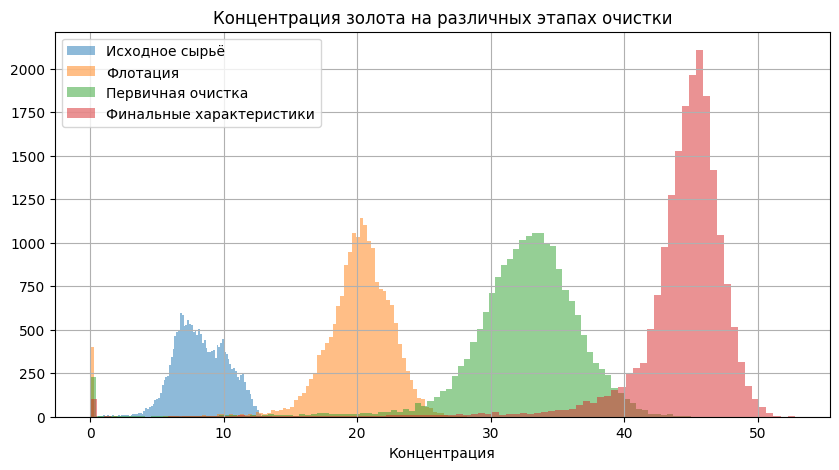

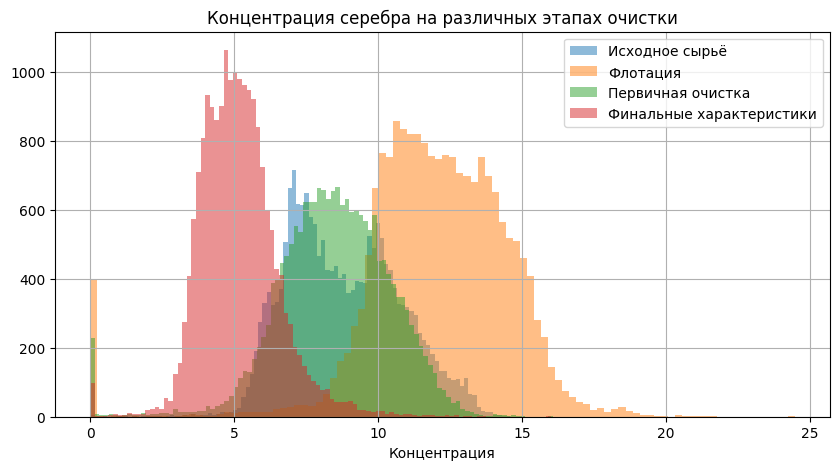

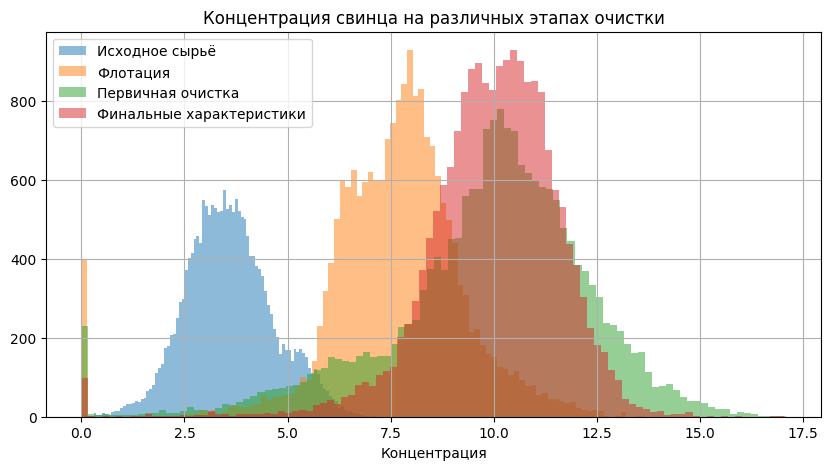

In [23]:
concentration('au', 'золота')
concentration('ag', 'серебра', 'right')
concentration('pb', 'свинца')

- **Концентрация золота возрастает.**
- **Концентрация серебра возрастает до флотации, затем падает.**
- **Концентрация свинца возрастает.**

### 4.2 Распределения размеров гранул сырья на разных выборках
Построим гистограммы.

In [24]:
def sizes(eng_stage, rus_stage):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    sns.kdeplot(train_df[eng_stage + '.input.feed_size'], label='Обучающая выборка')
    sns.kdeplot(test_df[eng_stage + '.input.feed_size'], label='Тестовая выборка')
    
    ax.set_xlabel('Размер', size=15)
    ax.set_ylabel('Плотность', size=15)
    ax.set_title('Распределения размеров гранул сырья на разных выборках при ' + rus_stage + "\n", size=18)
    ax.legend(loc='upper right', prop={'size': 15}) 
    ax.grid()
    
    plt.show()

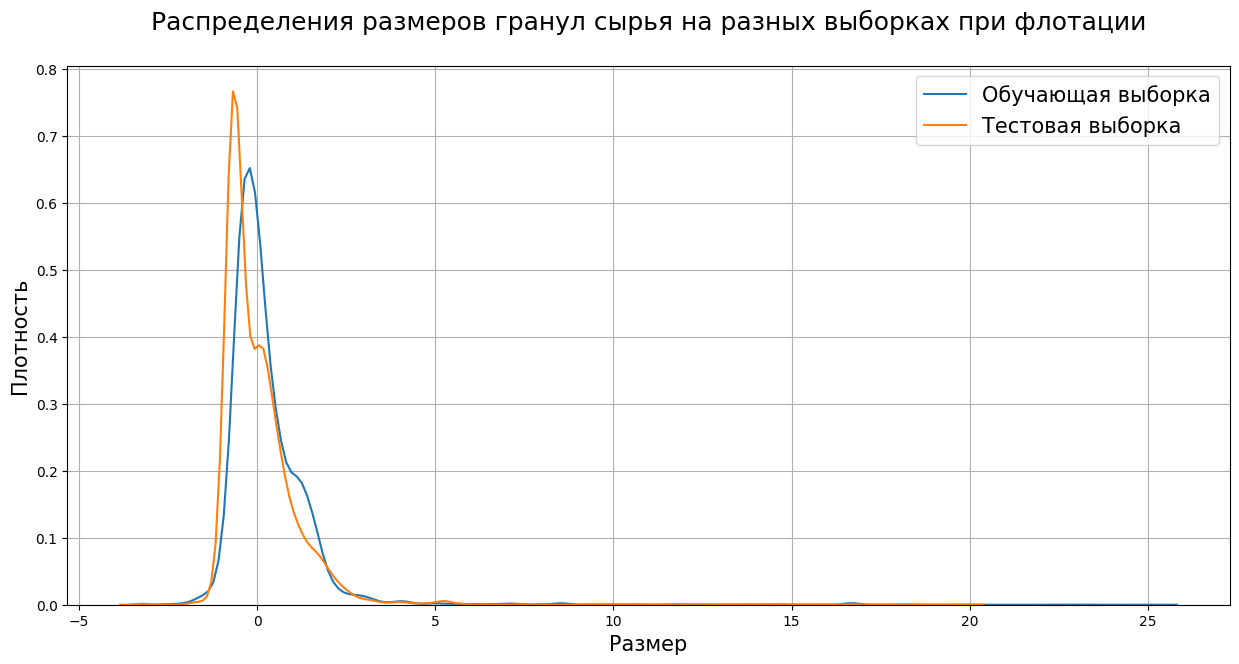

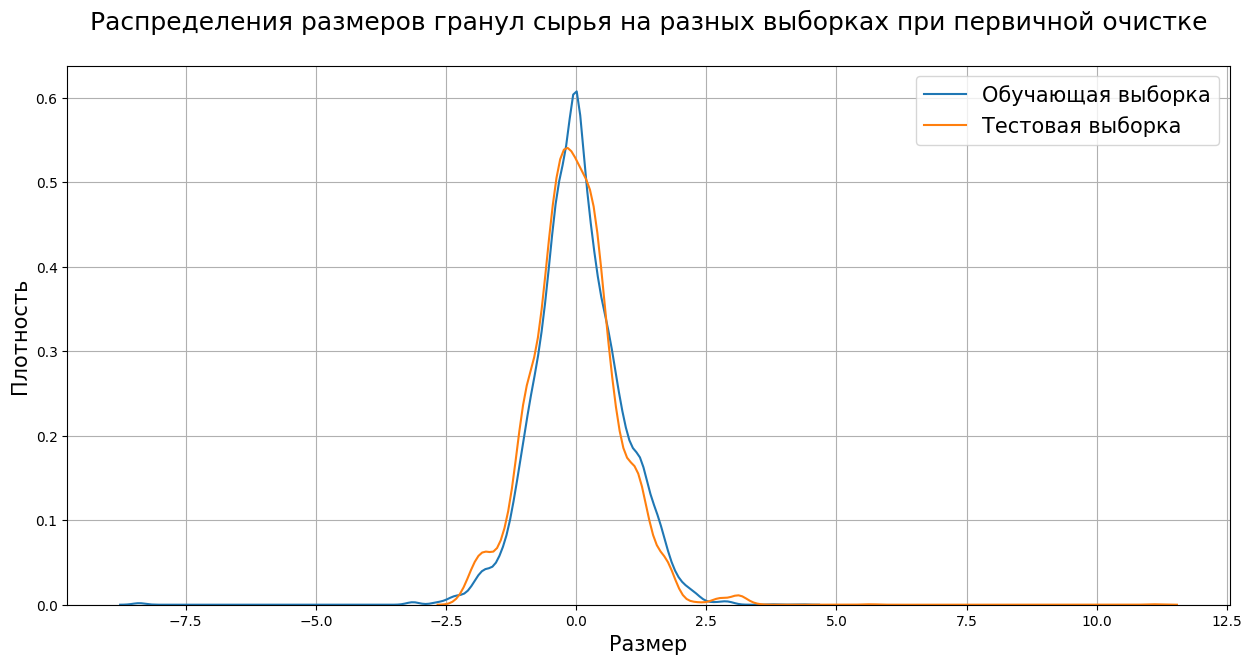

In [25]:
sizes('rougher', 'флотации')
sizes('primary_cleaner', 'первичной очистке')

**Распределения очень схожи, значит данные можно использовать для модели.**

### 4.3 Суммарная концентрация всех веществ на разных стадиях
Просуммируем концентрации и добавим в новый датафрейм.

In [26]:
stages = ['rougher', 'primary_cleaner', 'final']
substances = ['au', 'ag', 'pb', 'sol']

columns = []
for substance in substances:
    columns.append('rougher.input.feed_' + substance)

for stage in stages:
    for substance in substances:
        columns.append(stage + '.output.concentrate_' + substance)

In [27]:
sum_concentrations_df = pd.DataFrame()

sum_concentrations_df['В сырье'] = full_df[columns[:4]].sum(axis=1)
sum_concentrations_df['В черновом'] = full_df[columns[4:8]].sum(axis=1)
sum_concentrations_df['В первичной очистке'] = full_df[columns[8:12]].sum(axis=1)
sum_concentrations_df['В финальном'] = full_df[columns[12:]].sum(axis=1)

Построим гистограммы.

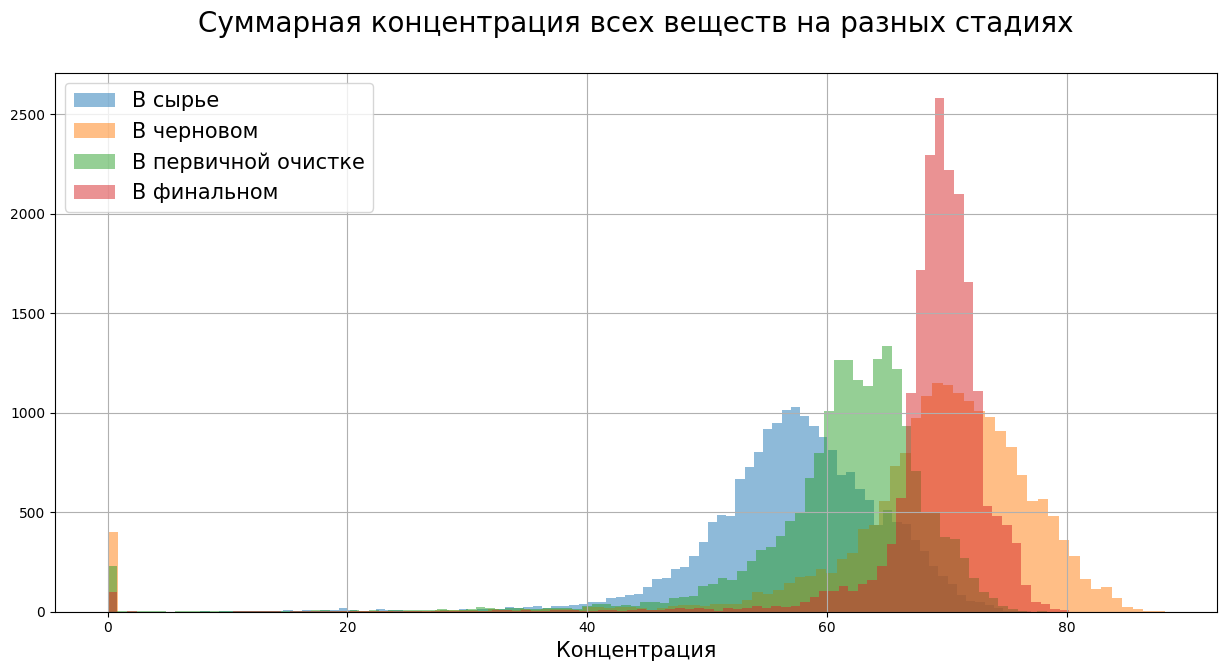

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))

for column in sum_concentrations_df.columns:
    ax.hist(sum_concentrations_df[column], bins=bins, label=column, alpha=alpha)

ax.set_xlabel('Концентрация', size=15)
ax.set_title('Суммарная концентрация всех веществ на разных стадиях' + "\n", size=20)
ax.legend(loc='upper left', prop={'size': 15}) 
ax.grid()
    
plt.show()

**Суммарная концентрация всех веществ плавно возрастает.**

На графике также видны аномалии около 0, избавимся от них в суммарном датафрейме.

In [29]:
for col in sum_concentrations_df.columns:
    sum_concentrations_df = sum_concentrations_df[sum_concentrations_df[col]>0]

Сохраним в обучающей выборке только строки без аномалий.

In [30]:
train_df = train_df.loc[train_df.index.isin(sum_concentrations_df.index)]
y_train_rougher = y_train_rougher.loc[y_train_rougher.index.isin(sum_concentrations_df.index)]
y_train_final = y_train_final.loc[y_train_final.index.isin(sum_concentrations_df.index)]

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Результаты исследовательского анализа:</b>
        <li>Концентрация золота на различных этапах очистки возрастает.</li>
        <li>Концентрация серебра на различных этапах очистки возрастает до флотации, затем падает.</li>
        <li>Концентрация свинца на различных этапах очистки возрастает.</li>
        <li>Распределения размеров гранул сырья на разных выборках очень схожи, значит данные можно использовать для модели.</li> 
        <li>Суммарная концентрация всех веществ плавно возрастает.</li>
        <li>Устранены аномалии.</li>
    </p>
            
    
</div>

## 5 Работа с моделями
Напишем функцию для вычисления sMAPE.

In [31]:
def smape(y_test, predictions):
    return 1/len(y_test) * np.sum(2 * np.abs(predictions - y_test) / (np.abs(y_test) + np.abs(predictions)) * 100)

In [32]:
def final_smape(rougher, final):
    print('Итоговая sMAPE:', 0.25 * rougher + 0.75 * final)

### 5.1 Обучение
Обучим разные модели без параметров и выберем лучшую.
#### Флотация

In [44]:
RANDOM_STATE = 0

def quality(mdl, y_train=y_train_rougher, return_qual=0):
    scores = cross_val_score(mdl, train_df, y_train, cv=5, scoring=make_scorer(smape, greater_is_better=False))
    quality = -scores.mean()
    print('Качество:', quality)
    
    if return_qual == 1:
        return quality

In [45]:
%%time
quality(LinearRegression())

Качество: 7.265696047566257
CPU times: total: 469 ms
Wall time: 413 ms


In [46]:
%%time
quality(DecisionTreeRegressor(random_state=RANDOM_STATE))

Качество: 13.856901378696659
CPU times: total: 5.92 s
Wall time: 6.07 s


In [47]:
%%time
quality(RandomForestRegressor(random_state=RANDOM_STATE))

Качество: 7.0491046227673255
CPU times: total: 11min 19s
Wall time: 11min 28s


Лучшим себя показал случайный лес.

#### Финальные характеристики

In [48]:
%%time
quality(LinearRegression(), y_train=y_train_final)

Качество: 10.950532500993408
CPU times: total: 469 ms
Wall time: 377 ms


In [49]:
%%time
quality(DecisionTreeRegressor(random_state=RANDOM_STATE), y_train=y_train_final)

Качество: 15.412479972987814
CPU times: total: 6.69 s
Wall time: 6.73 s


In [50]:
%%time
quality(RandomForestRegressor(random_state=RANDOM_STATE), y_train=y_train_final)

Качество: 9.739822846447975
CPU times: total: 12min 50s
Wall time: 12min 57s


Лучшим себя показал случайный лес.

### 5.2 Подбор гиперпараметров
#### Флотация

In [55]:
rf_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 100, 1)),
        'max_features': hp.choice('max_features', range(1,5)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 50, 1)), 
        'n_estimators': hp.choice('n_estimators', range(1,20))
        }

In [56]:
state = np.random.default_rng(RANDOM_STATE)

def hp_slctns(y_train=y_train_rougher):
    def func(args):
        mdl = RandomForestRegressor(random_state=RANDOM_STATE).set_params(**args)
        scores = cross_val_score(mdl, train_df, y_train, cv=5, 
                                 scoring=make_scorer(smape, greater_is_better=False), 
                                 error_score='raise')
        final_score = -sum(scores) / len(scores)
        return {'loss': final_score, 'status': STATUS_OK, 'model':mdl}
    
    trials = Trials()
    best = fmin(func,
                space=rf_space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=5, 
                show_progressbar=True, 
                rstate=state)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    return best_model

In [57]:
best_rougher_rf = hp_slctns()

100%|███████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/trial, best loss: 6.157107807328467]
Лучшие гиперпараметры: {'max_depth': 39.0, 'max_features': 1, 'min_samples_leaf': 21.0, 'min_samples_split': 36.0, 'n_estimators': 10}


#### Финальные характеристики

In [59]:
best_final_rf = hp_slctns(y_train=y_train_final)

100%|███████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/trial, best loss: 9.140613821067724]
Лучшие гиперпараметры: {'max_depth': 27.0, 'max_features': 1, 'min_samples_leaf': 45.0, 'min_samples_split': 26.0, 'n_estimators': 12}


### 5.3 Сравнение с константными моделями
Создадим функцию для создания таблицы результатов.

In [64]:
def results(y_train, y_test, best_model):
    dummy = quality(DummyRegressor(strategy='mean'), return_qual=1, y_train=y_train)
    
    results_df = pd.DataFrame(columns=['Качество', 'Время обучения', 'Скорость предсказания'])
    results_df.loc['Константная модель'] = [dummy, 0, 0]
    
    mdl = RandomForestRegressor(random_state=RANDOM_STATE).set_params(**best_model.get_params())
    
    start_train_timer = time.time()
    mdl.fit(train_df, y_train)
    stop_train_timer = time.time() - start_train_timer
    
    start_pred_timer = time.time()
    score = smape(y_test, mdl.predict(test_df))
    stop_pred_timer = time.time() - start_pred_timer
    
    results_df.loc['Случайный лес'] = [score, stop_train_timer, stop_pred_timer]
    return mdl, score, results_df

Создадим таблицы.

In [65]:
mdl_rougher, score_rougher, results_rougher_df = results(y_train=y_train_rougher, y_test=y_test_rougher, 
                                                         best_model=best_rougher_rf)
mdl_final, score_final, results_final_df = results(y_train=y_train_final, y_test=y_test_final, 
                                                   best_model=best_final_rf)

Качество: 7.803961504107102
Качество: 10.412752300489277


Рассмотрим получившееся таблицы.

In [66]:
results_rougher_df

,Качество,Время обучения,Скорость предсказания
Константная модель,7.803962,0.000000,0.000000
Случайный лес,8.720507,0.557094,0.021941


In [67]:
results_final_df

,Качество,Время обучения,Скорость предсказания
Константная модель,10.412752,0.000000,0.000000
Случайный лес,9.412608,0.584416,0.021907


### 5.4 Анализ важности признаков
#### Флотация

In [72]:
def feature_importances(mdl, y_train):
    importances = mdl.feature_importances_
    sorted_idx = importances.argsort()
    
    plt.figure(figsize=(15, 15))
    plt.barh(range(train_df.shape[1]), importances[sorted_idx])
    plt.yticks(range(train_df.shape[1]), train_df.columns[sorted_idx])
    plt.xlabel('Важность признаков', fontsize=16)
    plt.title('График важности признаков' + '\n', fontsize=20)
    plt.grid(True)
    plt.show()

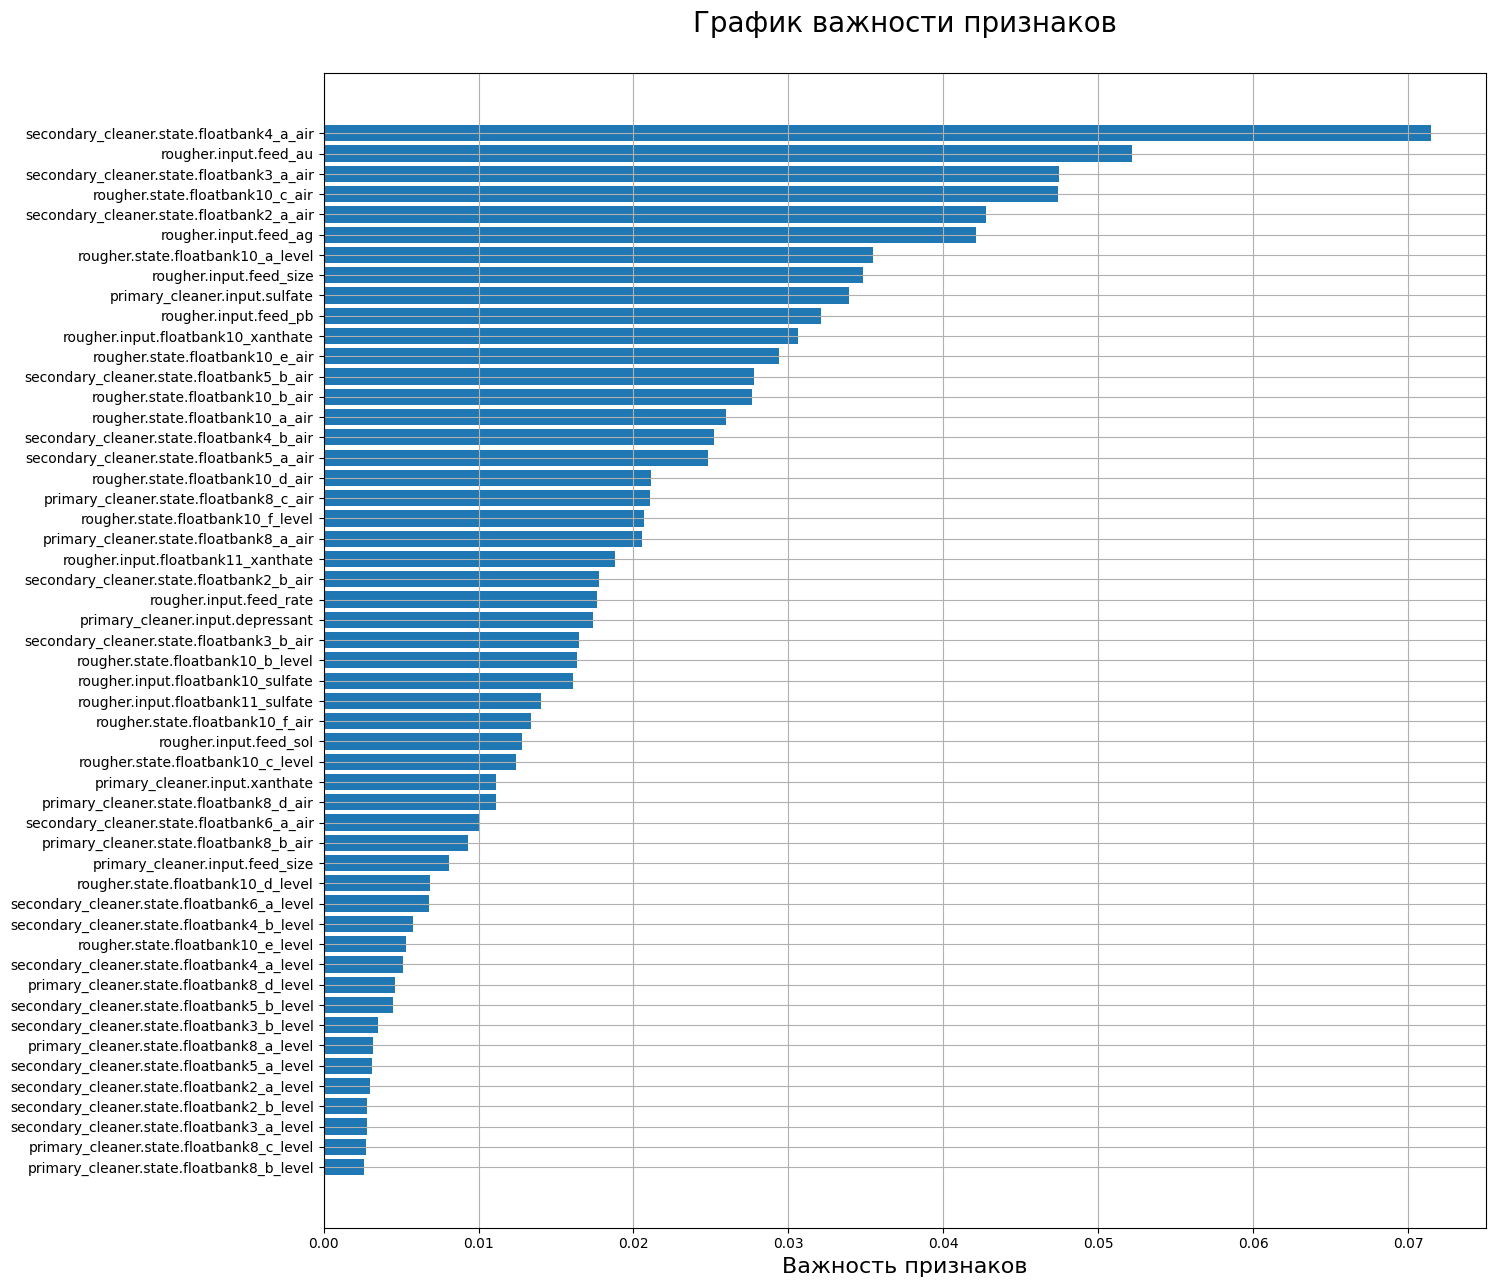

In [73]:
feature_importances(mdl=mdl_rougher, y_train=y_train_rougher)

#### Финальные характеристики

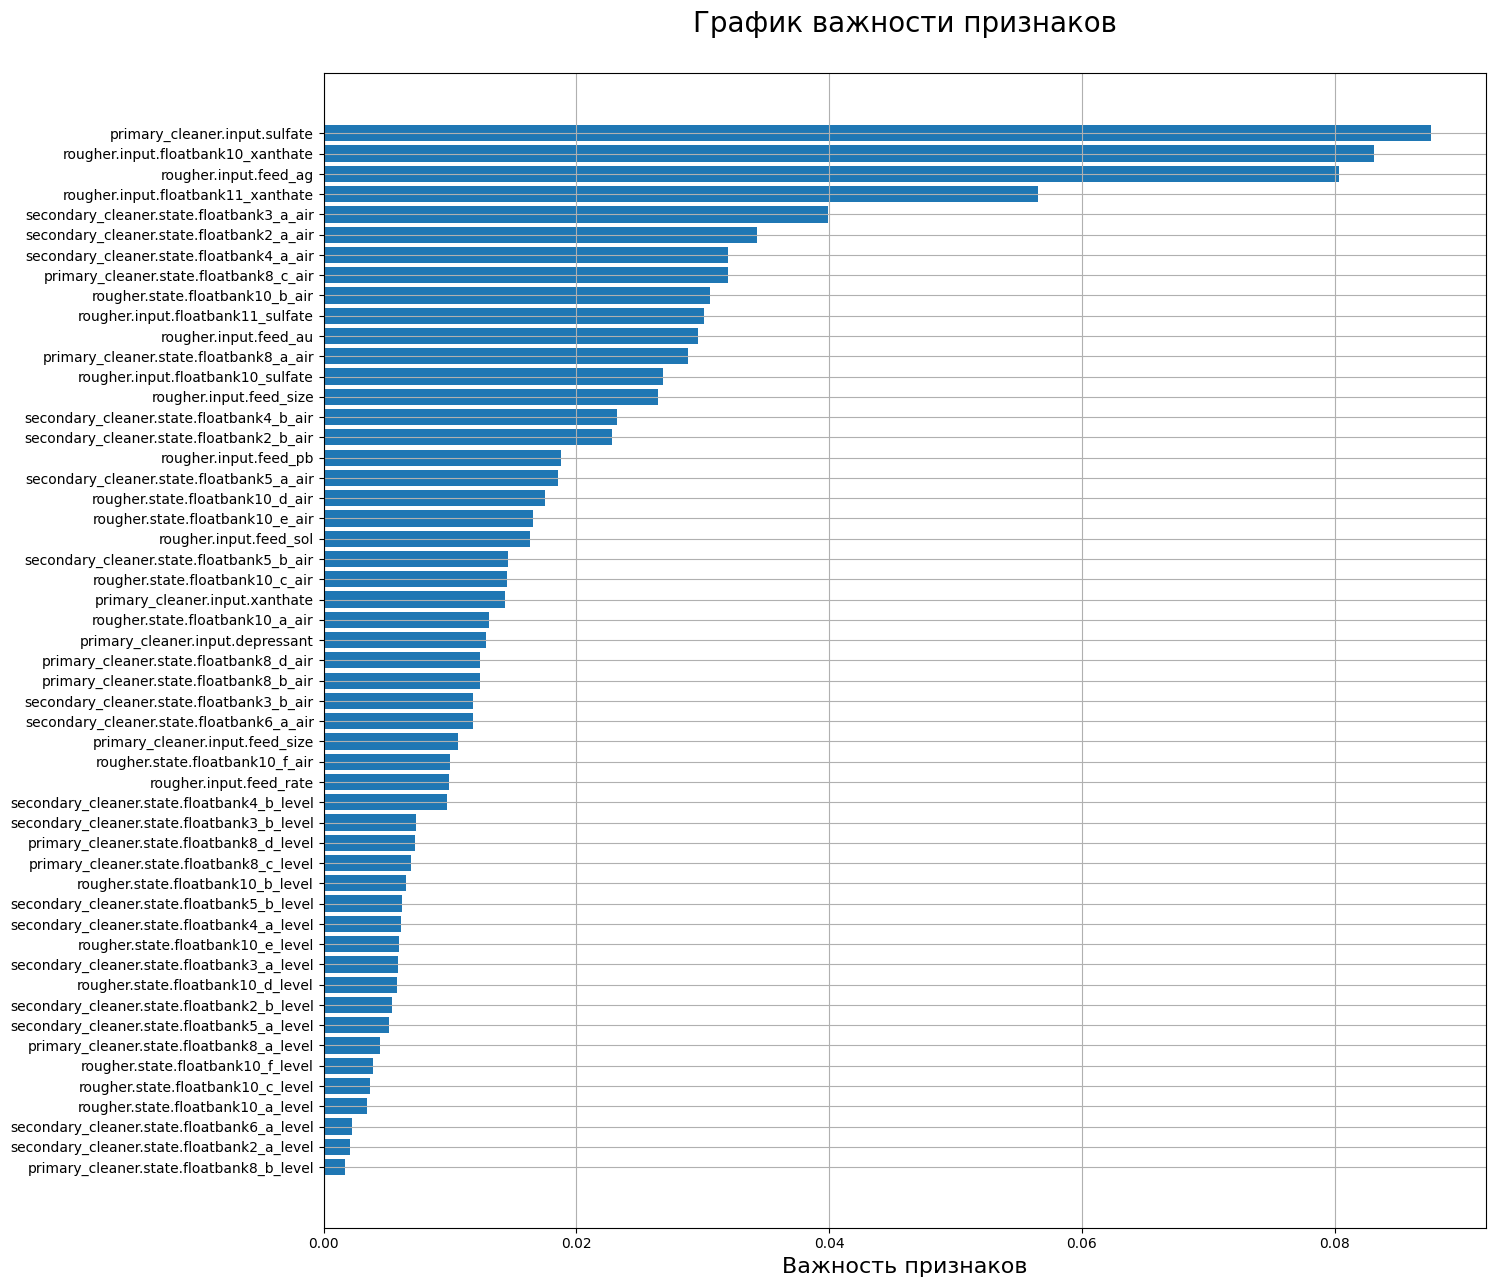

In [74]:
feature_importances(mdl=mdl_final, y_train=y_train_final)

### 5.5 Расчёт итоговой sMAPE

In [75]:
final_smape(score_rougher, score_final)

9.23958258947997

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты работы с моделями:</b>
        <ol>
        <li>Разные модели обучены.</li>
        <li>Лучшая модель найдена, сравнена с константной и проверена на тестовой выборке.</li>
        <li>Проведён анализ важности признаков.</li>
        <li>Рассчитана итоговая sMAPE.</li>
        </ol>
   </p>  
</div>

## 6 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">

### Описание ключевых шагов решения
1. При подготовке данных были обработаны пропуски, проверена правильность расчёта эффективности обогащения, проанализированы недоступные в тестовой выборке признаки и масштабированы численные признаки.
1. В результате исследовательского анализа выяснилось следующее:
   - Концентрация золота на различных этапах очистки возрастает;
   - Концентрация серебра на различных этапах очистки возрастает до флотации, затем падает;
   - Концентрация свинца на различных этапах очистки возрастает;
   - Распределения размеров гранул сырья на разных выборках очень схожи, значит данные можно использовать для модели;
   - Суммарная концентрация всех веществ плавно возрастает.
1. Были обучены разные модели и выбрана лучшая.
1. Лучшая модель была сравнена с константной и протестирована на тестовой выборке.

***

### Описание моделей
#### Флотация
Модель — `RandomForestRegressor`.

Гиперпараметры:
- `random_state` = 0
- `max_depth` = 39
- `max_features` = 1
- `min_samples_leaf` = 21
- `min_samples_split` = 36
- `n_estimators` = 10

#### Финальные характеристики
Модель — `RandomForestRegressor`.

Гиперпараметры:
- `random_state` = 0
- `max_depth` = 27
- `max_features` = 1
- `min_samples_leaf` = 45
- `min_samples_split` = 26
- `n_estimators` = 12

***

### Итоговая метрика
sMAPE 9.723603544543572

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">